In [65]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.linear_model import LogisticRegression

In [2]:
with open('location.pickle','rb') as read_file:
    location = pickle.load(read_file)

In [3]:
train, val = train_test_split(location, test_size=0.2, random_state=42)

In [132]:
train.head()

,longitude,latitude,status
92221,-87.664438,41.952835,0
108404,-87.636456,41.922143,0
95649,-87.629298,41.878016,0
155104,-87.629114,41.882203,1
937637,-87.644885,41.932950,0


## Simple Logistic Models

In [5]:
# Logistic Model on Geolocation
lm_loc = LogisticRegression(solver='newton-cg', C=10) 
lm_loc.fit(train[['latitude','longitude']], train['status'])


C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

intercept:  -12.5646
coef:  -3.6601


C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [6]:
train.status.value_counts()

0    371333
1    154783
Name: status, dtype: int64

In [7]:
val_c = val.copy()
val_c['pred'] = lm_loc.predict(val[['latitude','longitude']])
val_c.loc[:, 'pred'] = val_c['pred'].astype('category')
val_c['correct_pred'] = val_c['pred'] == val_c['status']

In [8]:
# This is the same model but with proba (returns probabilities instead of class)
val_c['proba_paid'] = lm_loc.predict_proba(val_c[['latitude','longitude']])[:, 1]
val_c.head()

,longitude,latitude,status,pred,correct_pred,proba_paid
284903,-87.674049,41.874593,0,0,True,0.310287
393992,-87.622130,41.885310,0,0,True,0.281763
688091,-87.644588,41.931651,0,0,True,0.256722
415767,-87.622130,41.885310,0,0,True,0.281763
732169,-87.641365,41.916676,1,0,False,0.266133


In [9]:
cf_matrix = confusion_matrix(val_c['status'], val_c['pred'])
cf_matrix

array([[93039,    12],
       [38467,    11]], dtype=int64)

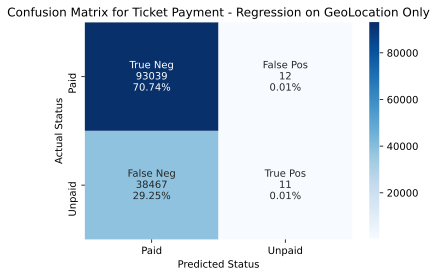

In [10]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
g = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels = ['Paid','Unpaid'], yticklabels = ['Paid','Unpaid'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Confusion Matrix for Ticket Payment - Regression on GeoLocation Only')
plt.show(g);

In [11]:
# test_c['ticket_queue'].astype('int32').dtypes
# mvp_eval['ticket_queue'].value_counts()
lm_loc.predict_proba(val[['latitude','longitude']])[:5]

array([[0.68971341, 0.31028659],
       [0.71823712, 0.28176288],
       [0.74327751, 0.25672249],
       [0.71823712, 0.28176288],
       [0.73386675, 0.26613325]])

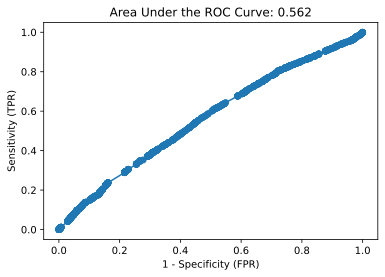

In [12]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)
    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");
    
fpr, tpr, thresholds = roc_curve(val_c['status'], val_c['proba_paid'])


plot_roc(val_c['status'], val_c['proba_paid'])

In [13]:
print("Accuracy: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(accuracy_score(val_c['status'], val_c['pred']), precision_score(val_c['status'], val_c['pred']), 
                                                     recall_score(val_c['status'], val_c['pred']),f1_score(val_c['status'], val_c['pred'], zero_division=1)))

Accuracy: 0.7074, Precision: 0.4783,   Recall: 0.0003,   F1: 0.0006


In [14]:
mask = tpr > 0.9
thresholds[mask].max()

0.2559227523799313

In [90]:
features1 = ['longitude','latitude']
X1=low_train[features1]
y1=low_train['status']
ros1 = RandomOverSampler(random_state=0)
X1_resampled, y1_resampled = ros1.fit_sample(X1,y1)

scaler1 = StandardScaler()
X1_train = scaler1.fit_transform(X1_resampled)
y1_train = y1_resampled

lm_loc1 = LogisticRegression(solver='newton-cg', C=10) 
lm_loc1.fit(X1_train, y1_resampled)

LogisticRegression(C=10, solver='newton-cg')

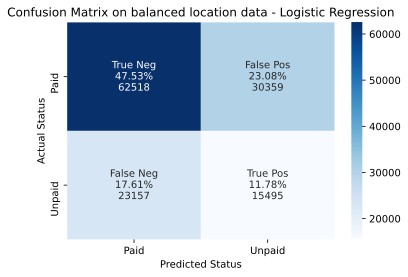

In [94]:
X1_val = scaler1.transform(data_val[features1])
preds1 = lm_loc1.predict(X1_val)

cf_matrix2 = confusion_matrix(data_val['status'], preds1)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix2.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix2.flatten()/np.sum(cf_matrix2)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
g = sns.heatmap(cf_matrix2, annot=labels, fmt='', cmap=plt.cm.Blues,xticklabels = ['Paid','Unpaid'], yticklabels = ['Paid','Unpaid'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Confusion Matrix on balanced location data - Logistic Regression')
plt.show(g);

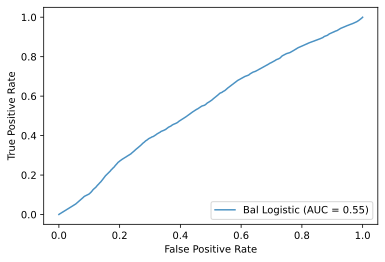

In [95]:
ax = plt.gca()

lm_disp = plot_roc_curve(lm_loc1, data_val[['latitude','longitude']], data_val['status'], ax=ax, alpha=0.8, name='Bal Logistic')

plt.show()

## Multiple features: Logistic Regression

In [15]:
# with open('table.pickle','rb') as read_file:
#     data = pickle.load(read_file)
    
with open('train_flip.pickle','rb') as read_file:
    data = pickle.load(read_file)
with open('test_flip.pickle','rb') as read_file:
    test = pickle.load(read_file)
    
data.dropna(inplace=True)
low_train, data_val = train_test_split(data, test_size=0.2, random_state=42, stratify=data['status'])

In [133]:
low_train = low_train.drop(columns=['hearing'])
low_train.head()

,longitude,latitude,code_0724225,code_0724226,code_0728440,code_0808060,code_0816020,code_0820015,code_0912060,code_0940060,...,code_0980110,code_0980120,code_0980130,code_0980220,code_1141115,code_1520270,freq,status,state,value
334131,-87.674049,41.874593,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,1,50
155429,-87.746065,41.907956,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,50
263660,-87.664438,41.952835,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,50
70248,-87.898200,41.981800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,60
213699,-87.741877,41.787874,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,25


In [17]:
from imblearn.over_sampling import RandomOverSampler

features = ['state', 'value','longitude','latitude','freq']
X=low_train[features]
y=low_train['status']
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X,y)

In [18]:
# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_resampled)
y_train = y_resampled

In [19]:
lm_2 = LogisticRegression(solver='newton-cg', C=10) 
lm_2.fit(X_train, y_train)

LogisticRegression(C=10, solver='newton-cg')

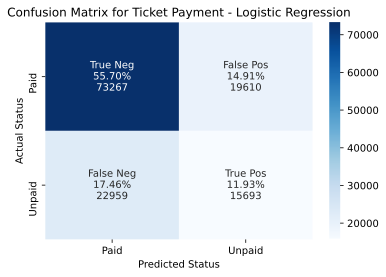

In [20]:
X_val = scaler.transform(data_val[features])
preds = lm_2.predict(X_val)

cf_matrix2 = confusion_matrix(data_val['status'], preds)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix2.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix2.flatten()/np.sum(cf_matrix2)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
g = sns.heatmap(cf_matrix2, annot=labels, fmt='', cmap=plt.cm.Blues,xticklabels = ['Paid','Unpaid'], yticklabels = ['Paid','Unpaid'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Confusion Matrix for Ticket Payment - Logistic Regression')
plt.show(g);

In [21]:
print("Accuracy: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(accuracy_score(data_val['status'], preds),precision_score(data_val['status'], preds), 
                                                     recall_score(data_val['status'], preds),f1_score(data_val['status'], preds, zero_division=1)))

Accuracy: 0.6764, Precision: 0.4445,   Recall: 0.4060,   F1: 0.4244


## Random Forest (TM)

In [23]:
from sklearn.ensemble import RandomForestClassifier
rc = RandomForestClassifier(n_estimators=100, max_features=4)
rc.fit(X,y)
y_hat_tr = rc.predict(X)
y_hat_te = rc.predict(data_val[features])
print("Accuracy: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(accuracy_score(data_val['status'],y_hat_te), precision_score(data_val['status'], y_hat_te), 
                                                     recall_score(data_val['status'], y_hat_te),f1_score(data_val['status'],y_hat_te, zero_division=1)))

Accuracy: 0.7262, Precision: 0.5898,   Recall: 0.2246,   F1: 0.3253


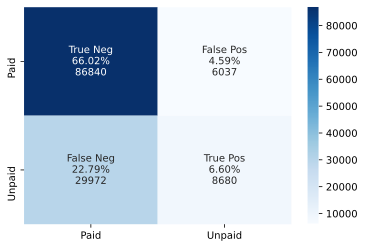

In [66]:
cf_matrixRF = confusion_matrix(data_val['status'], y_hat_te)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrixRF.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixRF.flatten()/np.sum(cf_matrixRF)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
sns.heatmap(cf_matrixRF, annot=labels, fmt='', cmap=plt.cm.Blues, xticklabels = ['Paid','Unpaid'], yticklabels = ['Paid','Unpaid']);

## RFC on balanced training set

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf_bal = RandomForestClassifier(n_estimators=100, max_features=4)
rf_bal.fit(X_resampled,y_resampled)
pred_bal = rf_bal.predict(X_resampled)
pred_rf_bal = rf_bal.predict(data_val[features])


In [26]:
print("Accuracy: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(accuracy_score(data_val['status'],pred_rf_bal) ,precision_score(data_val['status'], pred_rf_bal), 
                                                     recall_score(data_val['status'], pred_rf_bal),f1_score(data_val['status'],pred_rf_bal, zero_division=1)))

Accuracy: 0.6617, Precision: 0.4385,   Recall: 0.5395,   F1: 0.4838


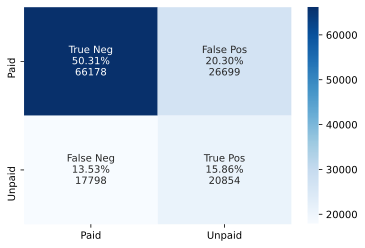

In [27]:
cf_matrix_rfbal = confusion_matrix(data_val['status'], pred_rf_bal)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix_rfbal.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix_rfbal.flatten()/np.sum(cf_matrix_rfbal)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
sns.heatmap(cf_matrix_rfbal, annot=labels, fmt='', cmap=plt.cm.Blues, xticklabels = ['Paid','Unpaid'], yticklabels = ['Paid','Unpaid']);

## Checking ROC curve for balanced logistic regression, unbalanced small RFC, and unbalanced large RFC with all features

In [28]:
from sklearn.metrics import plot_roc_curve


In [30]:
data_val[features]

,state,value,longitude,latitude,freq
384277,1,50,-87.617745,41.893702,1
111690,0,30,-87.626614,41.879319,1
454559,1,50,-87.594768,41.799798,1
87353,1,30,-87.648934,41.920127,1
496702,1,30,-87.639828,41.923948,1
...,...,...,...,...,...
941295,1,25,-87.622130,41.885310,1
382831,1,30,-87.644393,41.935019,1
519758,1,50,-87.622130,41.885310,1
728330,1,50,-87.645549,41.947778,1


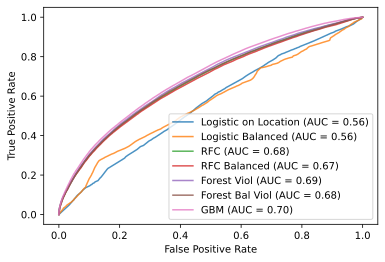

In [57]:
ax = plt.gca()

lm_disp = plot_roc_curve(lm_loc, data_val[['latitude','longitude']], data_val['status'], ax=ax, alpha=0.8, name='Logistic on Location')
lm_disp = plot_roc_curve(lm_2, data_val[features], data_val['status'], ax=ax, alpha=0.8, name='Logistic Balanced')
rc_disp = plot_roc_curve(rc, data_val[features], data_val['status'], ax=ax, alpha=0.8, name='RFC')
rc_bal = plot_roc_curve(rf_bal, data_val[features], data_val['status'], ax=ax, alpha=0.8, name='RFC Balanced')
viol_forest = plot_roc_curve(forest, data_val.drop(columns=['status']), data_val['status'], ax=ax, alpha=0.8, name='Forest Viol')
bal_viol = plot_roc_curve(balanced_forest, data_val.drop(columns=['status']), data_val['status'], ax=ax, alpha=0.8, name='Forest Bal Viol')
gbm_disp = plot_roc_curve(gbm, data_val[predictors].astype('float64'), data_val['status'].astype('float64'),  ax=ax, alpha=0.8, name='GBM')

plt.show()

## Random Forest With Violation Codes

In [134]:
X_big = low_train.drop(columns=['status'])
X_val = data_val.drop(columns=['status'])
y.describe()

count    526116.000000
mean          0.293869
std           0.455533
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: status, dtype: float64

In [135]:
X_big.head()

,longitude,latitude,code_0724225,code_0724226,code_0728440,code_0808060,code_0816020,code_0820015,code_0912060,code_0940060,...,code_0980080,code_0980110,code_0980120,code_0980130,code_0980220,code_1141115,code_1520270,freq,state,value
334131,-87.674049,41.874593,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,50
155429,-87.746065,41.907956,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,50
263660,-87.664438,41.952835,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,50
70248,-87.898200,41.981800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,60
213699,-87.741877,41.787874,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,25


In [137]:
forest = RandomForestClassifier(n_estimators=100, max_features=10)
forest.fit(X_big,y)
rf_preds= forest.predict(X_big)
rf_val_preds = forest.predict(X_val.drop(columns=['hearing']))

In [138]:
print("Accuracy: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(accuracy_score(data_val['status'],rf_val_preds), precision_score(data_val['status'],rf_val_preds), 
                                                     recall_score(data_val['status'],rf_val_preds),f1_score(data_val['status'],rf_val_preds, zero_division=1)))

Accuracy: 0.7263, Precision: 0.5798,   Recall: 0.2500,   F1: 0.3494


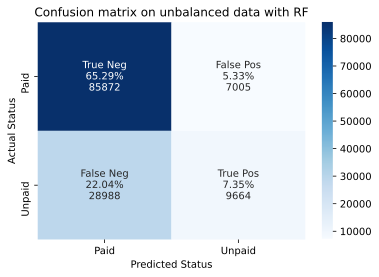

In [139]:
cf_mat = confusion_matrix(data_val['status'],rf_val_preds)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_mat.flatten()/np.sum(cf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.title('Confusion matrix on unbalanced data with RF')
sns.heatmap(cf_mat, annot=labels, fmt='', cmap=plt.cm.Blues, xticklabels = ['Paid','Unpaid'],  yticklabels = ['Paid','Unpaid'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status');

<BarContainer object of 10 artists>

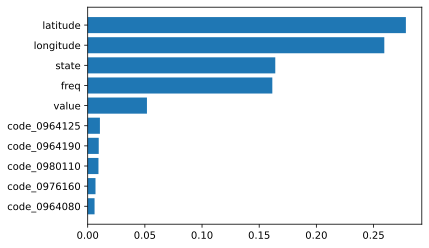

In [140]:
from sklearn.inspection import permutation_importance
sorted_idx = forest.feature_importances_.argsort()[-10:]
plt.barh(X_big.columns[sorted_idx], forest.feature_importances_[sorted_idx])

## Let's balance the data again for that

In [141]:
ros = RandomOverSampler(random_state=0)
X_big_resampled, y_resampled = ros.fit_sample(X_big,y)


In [142]:
balanced_forest = RandomForestClassifier(n_estimators=100, max_features=10)
balanced_forest.fit(X_big_resampled,y_resampled)
bal_preds= balanced_forest.predict(X_big_resampled)
bal_val_preds = balanced_forest.predict(X_val.drop(columns=['hearing']))

In [143]:
print("Accuracy: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(accuracy_score(data_val['status'],bal_val_preds), precision_score(data_val['status'],bal_val_preds), 
                                                     recall_score(data_val['status'],bal_val_preds),f1_score(data_val['status'],bal_val_preds, zero_division=1)))

Accuracy: 0.6639, Precision: 0.4407,   Recall: 0.5342,   F1: 0.4830


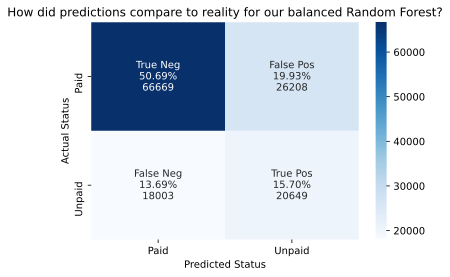

In [144]:
cf_mat = confusion_matrix(data_val['status'],bal_val_preds)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_mat.flatten()/np.sum(cf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.title('How did predictions compare to reality for our balanced Random Forest?')
sns.heatmap(cf_mat, annot=labels, fmt='', cmap=plt.cm.Blues, xticklabels = ['Paid','Unpaid'], yticklabels = ['Paid','Unpaid'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status');

Text(0.5, 1.0, 'Which features were used most often in trees throughout forest')

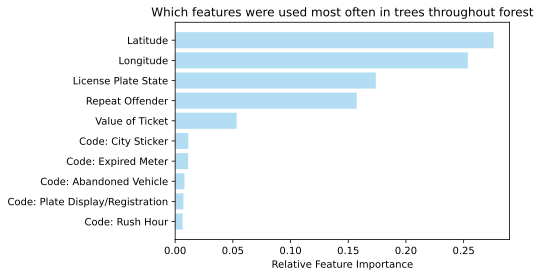

In [148]:
sorted_idx = balanced_forest.feature_importances_.argsort()[-10:]
labels = ['Latitude','Longitude','License Plate State','Repeat Offender','Value of Ticket','Code: City Sticker','Code: Expired Meter','Code: Abandoned Vehicle','Code: Plate Display/Registration','Code: Rush Hour']
positions = [9,8,7,6,5,4,3,2,1,0]
plt.barh(X_big.columns[sorted_idx], balanced_forest.feature_importances_[sorted_idx], color='#b3ddf2')
plt.yticks(positions, labels)
plt.xlabel('Relative Feature Importance')
plt.title('Which features were used most often in trees throughout forest')

In [ ]:
0976160: Plate display or registration
0964125: City sticker
0964150: Parking/Standing prohibited
0964040: Street cleaning/Special event
0964190: Expired Meter
0980110: Abandondoned/Hazardous Vehicle

## K Nearest Neighbors Models

In [ ]:
import itertools
from sklearn import metrics
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn.neighbors import KNeighborsClassifier


### Let's take a quick look at a KNN model based on the four closest neighbors

### DO NOT RUN UNLESS YOU WANT TO WAIT AT LEAST 30 MINUTES

In [ ]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_resampled,y_resampled)
yhat = neigh.predict(data_test[features])
print("Train set Accuracy: ", metrics.accuracy_score(y_resampled, neigh.predict(X_resampled)))
print("Test set Accuracy: ", metrics.accuracy_score(data_test['status'], yhat))

### Diving deeper and evaluating other KNN across values of k and multiple metrics

### DO NOT RUN UNLESS YOU WANT TO WAIT 10 YEARS

In [ ]:
Ks = 10
mean_acc = np.zeros((Ks-1))
mean_f1 = np.zeros((Ks-1))
mean_prec = np.zeros((Ks-1))
mean_recall = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_resampled,y_resampled)
    yhat = neigh.predict(data_test[features])
    mean_acc[n-1] = metrics.accuracy_score(data_test['status'], yhat)
    mean_f1[n-1]= f1_score(data_test['status'], yhat, zero_division=1)
    mean_prec[n-1] = precision_score(data_test['status'], yhat)
    mean_recall[n-1] = recall_score(data_test['status'], yhat)
    
    
#     std_acc[n-1]=np.std(yhat==data_test['status'])/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.plot(range(1,Ks),mean_f1,'b')
plt.plot(range(1,Ks),mean_prec,'r')
plt.plot(range(1,Ks),mean_recall,'y')
# plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
# plt.fill_between(range(1,Ks),mean_f1 - 1 * std_acc,mean_f1+ 1 * std_acc, alpha=0.10)
# plt.fill_between(range(1,Ks),mean_prec - 1 * std_acc,mean_prec+ 1 * std_acc, alpha=0.10)
# plt.fill_between(range(1,Ks),mean_recall - 1 * std_acc,mean_recall+ 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ','F1','Precision','Recall'))
plt.ylabel('Metrics')
plt.xlabel('Number of Nabors (K)')
plt.title('Accuracy, F1, Precision, and Reall scores for KNN across many values of k')
plt.tight_layout()
plt.show()

In [ ]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
print( "The best F1 Score was with", mean_f1.max(), "with k=", mean_f1.argmax()+1) 
print( "The best precision was with", mean_prec.max(), "with k=", mean_prec.argmax()+1) 
print( "The best recall was with", mean_recall.max(), "with k=", mean_recall.argmax()+1) 

## XGBOOST AREA

In [46]:
import xgboost as xgb

In [149]:
predictors = [x for x in low_train.columns if x not in ['status','hearing']]
predictors
X_big_resampled.dtypes

longitude       float64
latitude        float64
code_0724225      UInt8
code_0724226      UInt8
code_0728440      UInt8
                 ...   
code_1141115      UInt8
code_1520270      UInt8
freq              int64
state             int32
value             Int64
Length: 68, dtype: object

In [150]:
X_ = X_big_resampled.astype('float32')
y_ = y_resampled.astype('float32')
X_val = data_val[predictors].astype('float32')
y_val = data_val['status'].astype('float32')

In [156]:
gbm = xgb.XGBClassifier( 
        n_estimators=1000,
        max_depth=5,
        objective='binary:logistic',
        use_label_encoder=False,
        learning_rate=.04, 
        subsample=.8,
        min_child_weight=3,
        colsample_bytree=.8
        )

eval_set=[(X_,y_),(X_val,y_val)]

fit_model = gbm.fit(
                X_, y_, 
                eval_set=eval_set,
                eval_metric='auc', 
                early_stopping_rounds=50,
                verbose=False)



In [157]:
acc = accuracy_score(test['status'].astype('float32'), gbm.predict(test[predictors].astype('float32'), ntree_limit=gbm.best_ntree_limit))
rec = recall_score(test['status'].astype('float32'), gbm.predict(test[predictors].astype('float32'), ntree_limit=gbm.best_ntree_limit))
prec = precision_score(test['status'].astype('float32'), gbm.predict(test[predictors].astype('float32'), ntree_limit=gbm.best_ntree_limit))
f1 = f1_score(test['status'].astype('float32'), gbm.predict(test[predictors].astype('float32'), ntree_limit=gbm.best_ntree_limit))
print('Accuracy: ',acc, '\n','Recall: ',rec, '\n','Precision: ',prec, '\n','f1 score: ',f1)

Accuracy:  0.6431919182107385 
 Recall:  0.5807725357011334 
 Precision:  0.4257964840703186 
 f1 score:  0.4913540927422845


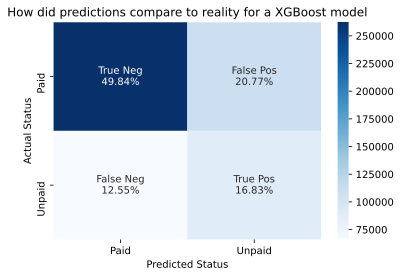

In [176]:
cf_mat = confusion_matrix(low_train['status'].astype('float32'), gbm.predict(low_train[predictors].astype('float32')))


group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ['{0:0.0f}'.format(value) for value in
#                 cf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_mat.flatten()/np.sum(cf_mat)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.title('How did predictions compare to reality for a XGBoost model')
sns.heatmap(cf_mat, annot=labels, fmt='', cmap=plt.cm.Blues, xticklabels = ['Paid','Unpaid'], yticklabels = ['Paid','Unpaid'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status');

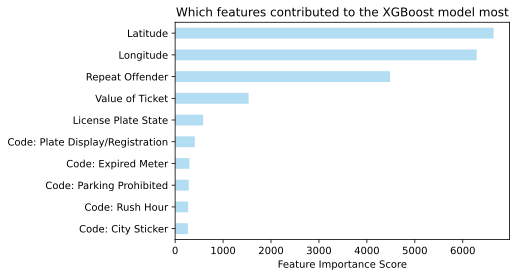

In [161]:
feat_imp = pd.Series(gbm.get_booster().get_fscore()).sort_values(ascending=True).tail(10)
feat_imp.plot(kind='barh', title='Which features contributed to the XGBoost model most',color='#b3ddf2')
labels = ['Latitude','Longitude','Repeat Offender','Value of Ticket','License Plate State','Code: Plate Display/Registration','Code: Expired Meter','Code: Parking Prohibited','Code: Rush Hour','Code: City Sticker']
positions = [9,8,7,6,5,4,3,2,1,0]
plt.yticks(positions, labels)
plt.xlabel('Feature Importance Score');

0976160: Plate display or registration
0964125: City sticker
0964150: Parking/Standing prohibited
0964040: Street cleaning/Special event
0964190: Expired Meter
0980110: Abandondoned/Hazardous Vehicle


In [ ]:
gbm = xgb.XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.5, 
        subsample=.8,
        min_child_weight=3,
        colsample_bytree=.8
        )

eval_set=[(X_resampled,y_resampled),(data_val[features],data_val['status'])]

fit_model = gbm.fit(
                X_resampled, y_resampled, 
                eval_set=eval_set,
                eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                early_stopping_rounds=50,
                verbose=False)

accuracy_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
recall_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
precision_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
f1_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
print('Accuracy: ',acc, '\n','Recall: ',rec, '\n','Precision: ',prec, '\n','f1 score: ',f1)

In [ ]:
cf_mat = confusion_matrix(test['status'].astype('float64'),gbm.predict(test[features].astype('float64')))


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_mat.flatten()/np.sum(cf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
sns.heatmap(cf_mat, annot=labels, fmt='', cmap=plt.cm.Blues, yticklabels = ['Paid','Unpaid']);

In [ ]:
preds = [x for x in low_train.columns if x not in ['status']]
preds

## Comparison of all models so far based on ROC Curve and AUC scores on validation data

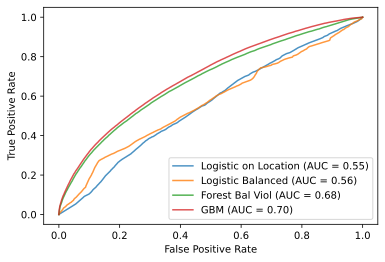

In [97]:
ax = plt.gca()

lm_disp = plot_roc_curve(lm_loc1, data_val[['latitude','longitude']], data_val['status'], ax=ax, alpha=0.8, name='Logistic on Location')
lm_disp = plot_roc_curve(lm_2, data_val[features], data_val['status'], ax=ax, alpha=0.8, name='Logistic Balanced')
bal_viol = plot_roc_curve(balanced_forest, data_val.drop(columns=['status']), data_val['status'], ax=ax, alpha=0.8, name='Forest Bal Viol')
gbm_disp = plot_roc_curve(gbm, data_val[predictors].astype('float64'), data_val['status'].astype('float64'),  ax=ax, alpha=0.8, name='GBM')

plt.show()

# Scoring on TEST DATA

### In this section, I have created new confusion matrices and recalculated metrics for the previously created XGBoost and Random Forest models for comparison on the test data

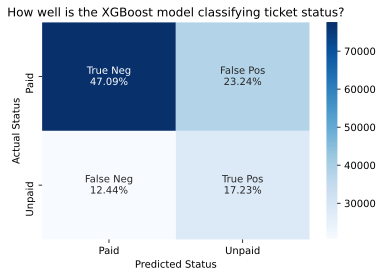

In [177]:
cf_mat = confusion_matrix(test['status'].astype('float32'),gbm.predict(test[predictors].astype('float32')) )
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_mat.flatten()/np.sum(cf_mat)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.title('How well is the XGBoost model classifying ticket status?')
sns.heatmap(cf_mat, annot=labels, fmt='', cmap=plt.cm.Blues, xticklabels = ['Paid','Unpaid'], yticklabels = ['Paid','Unpaid'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status');

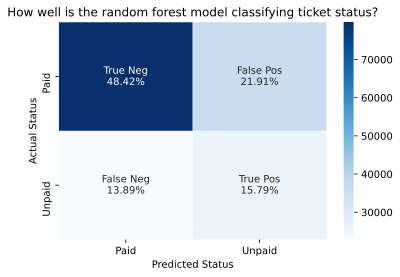

In [178]:
cf_mat = confusion_matrix(test['status'],balanced_forest.predict(test.drop(columns=['status','hearing'])))


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_mat.flatten()/np.sum(cf_mat)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.title('How well is the random forest model classifying ticket status?')
sns.heatmap(cf_mat, annot=labels, fmt='', cmap=plt.cm.Blues, xticklabels = ['Paid','Unpaid'], yticklabels = ['Paid','Unpaid'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status');

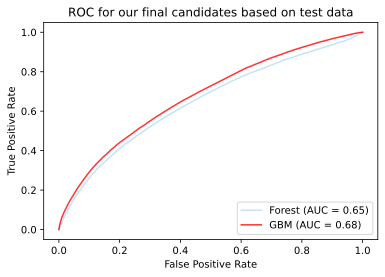

In [166]:
ax = plt.gca()

bal_viol = plot_roc_curve(balanced_forest, test.drop(columns=['status','hearing']), test['status'], ax=ax, alpha=0.8, name='Forest',color='#b3ddf2')
gbm_disp = plot_roc_curve(gbm, test[predictors].astype('float64'), test['status'].astype('float64'),  ax=ax, alpha=0.8, name='GBM',color='#ff0000')
plt.title('ROC for our final candidates based on test data')
plt.show()

In [162]:
acc = accuracy_score(test['status'].astype('float32'), gbm.predict(test[predictors].astype('float32'), ntree_limit=gbm.best_ntree_limit))
rec = recall_score(test['status'].astype('float32'), gbm.predict(test[predictors].astype('float32'), ntree_limit=gbm.best_ntree_limit))
prec = precision_score(test['status'].astype('float32'), gbm.predict(test[predictors].astype('float32'), ntree_limit=gbm.best_ntree_limit))
f1 = f1_score(test['status'].astype('float32'), gbm.predict(test[predictors].astype('float32'), ntree_limit=gbm.best_ntree_limit))
print('GBM Scores','\n','Accuracy: ',round(acc,4), '\n','Recall: ',round(rec,4), '\n','Precision: ',round(prec,4), '\n','f1 score: ',round(f1,4))

GBM Scores 
 Accuracy:  0.6432 
 Recall:  0.5808 
 Precision:  0.4258 
 f1 score:  0.4914


In [164]:
test_preds = balanced_forest.predict(test.drop(columns=['status','hearing']))
print('Forest Scores','\n','Accuracy: {:6.4f}'.format(accuracy_score(test['status'],test_preds)),'\n','Recall: {:6.4f}'.format(recall_score(test['status'],test_preds)),'\n', 'Precision: {:6.4f}'.format(precision_score(test['status'],test_preds)),'\n', 'F1: {:6.4f}'.format(f1_score(test['status'],test_preds, zero_division=1)))

Forest Scores 
 Accuracy: 0.6421 
 Recall: 0.5321 
 Precision: 0.4188 
 F1: 0.4687


## Exploring Errors

In [188]:
df = test
df['preds'] = gbm.predict(test[predictors].astype('float32'), ntree_limit=gbm.best_ntree_limit)
df['false pos'] = ((df.preds == 1) & (df.status ==0))
df['false neg'] = ((df.preds == 0) & (df.status ==1))
df['true pos'] = ((df.preds == 1) & (df.status ==1))
df['true neg'] = ((df.preds == 0) & (df.status ==0))

In [193]:
df[df['preds'] == 1].value.mean()

51.60264294714106

In [194]:
df[df['preds'] == 0].value.mean()

42.89154291775457

In [189]:
df[df['false pos'] == 1].value.mean()

51.516287453305814

In [190]:
df[df['false neg'] == 1].value.mean()

43.925137865404324

In [191]:
df[df['true pos'] == 1].value.mean()

51.719096769648075

In [192]:
df[df['true neg'] == 1].value.mean()

42.61846126075016

In [195]:
print('Avg Latitude of Pred Unpaid: ', df[df['preds'] == 1].latitude.mean())
print('Avg Latitude of Pred Paid: ', df[df['preds'] == 0].latitude.mean())
print('Avg Longitude of Pred Unpaid: ', df[df['preds'] == 1].longitude.mean())
print('Avg Longitude of Pred Paid: ', df[df['preds'] == 0].longitude.mean())

Avg Latitude of Pred Unpaid:  41.87736311168559
Avg Latitude of Pred Paid:  41.906104908561055
Avg Longitude of Pred Unpaid:  -87.67083212814228
Avg Longitude of Pred Paid:  -87.66720071267565


In [196]:
print('Avg Latitude of False Pos: ', df[df['false pos'] == 1].latitude.mean())
print('Avg Latitude of False Neg: ', df[df['false neg'] == 0].latitude.mean())
print('Avg Latitude of True Pos: ', df[df['true pos'] == 1].latitude.mean())
print('Avg Latitude of True Neg: ', df[df['true neg'] == 0].latitude.mean())
print('Avg Longitude of False Pos: ', df[df['false pos'] == 1].longitude.mean())
print('Avg Longitude of False Neg: ', df[df['false neg'] == 0].longitude.mean())
print('Avg Longitude of True Pos: ', df[df['true pos'] == 1].longitude.mean())
print('Avg Longitude of True Neg: ', df[df['true neg'] == 0].longitude.mean())

Avg Latitude of False Pos:  41.87663085867329
Avg Latitude of False Neg:  41.89303648794809
Avg Latitude of True Pos:  41.87835058403258
Avg Latitude of True Neg:  41.88376042016164
Avg Longitude of False Pos:  -87.67011724053391
Avg Longitude of False Neg:  -87.66823072822793
Avg Longitude of True Pos:  -87.6717961825495
Avg Longitude of True Neg:  -87.67105165657014


In [197]:
print('Avg Frequency False Pos: ', df[df['false pos'] == 1].freq.mean())
print('Avg Frequency of False Neg: ', df[df['false neg'] == 0].freq.mean())
print('Avg Frequency of True Pos: ', df[df['true pos'] == 1].freq.mean())
print('Avg Frequency of True Neg: ', df[df['true neg'] == 0].freq.mean())

Avg Frequency False Pos:  1.2045401112823595
Avg Frequency of False Neg:  1.2918218062055815
Avg Frequency of True Pos:  1.3470955014619368
Avg Frequency of True Neg:  1.2670751155933409


In [204]:
print('Avg Value Pred Unpaid: ', round(df[df['preds'] == 1].value.mean(),2))
print('Avg Value Pred Paid: ', round(df[df['preds'] == 0].value.mean(),2))
print('Avg Value of False Pos: ', round(df[df['false pos'] == 0].value.mean(),2))
print('Avg Value of False Neg: ', round(df[df['false neg'] == 0].value.mean(),2))
print('Avg Value of True Pos: ', round(df[df['true pos'] == 0].value.mean(),2))
print('Avg Value of True Neg: ', round(df[df['true neg'] == 0].value.mean(),2))

Avg Value Pred Unpaid:  51.6
Avg Value Pred Paid:  42.89
Avg Value of False Pos:  44.87
Avg Value of False Neg:  46.77
Avg Value of True Pos:  45.31
Avg Value of True Neg:  49.8


## Pickles for Models

In [55]:
# Logistic Model on GeoData
filename = 'chimodel_log1.sav'
pickle.dump(lm_loc, open(filename, 'wb'))

# Logistic Model on multiple features (not violations)
filename = 'chimodel_log2.sav'
pickle.dump(lm_2, open(filename, 'wb'))

# Random Forest on multiple features (not violations)
filename = 'chimodel_rfc2.sav'
pickle.dump(rc, open(filename, 'wb'))

# Random forest on balanced data (not violations)
filename = 'chimodel_rfc2.sav'
pickle.dump(rf_bal, open(filename, 'wb'))

#Random forest on all features (unbalanced)
filename = 'chimodel_rfc3.sav'
pickle.dump(forest, open(filename, 'wb'))

#Random forest on all features (balanced)
filename = 'chimodel_rfc4.sav'
pickle.dump(balanced_forest, open(filename, 'wb'))

# xgboost on all features (balanced)
filename = 'chimodel_xgb1.sav'
pickle.dump(gbm, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

In [115]:
cf_matrix

array([[93039,    12],
       [38467,    11]], dtype=int64)

In [126]:
# matrix = np.array([['A','B'],['C','D']])
matrix = np.array([[6,1],[1,2]])

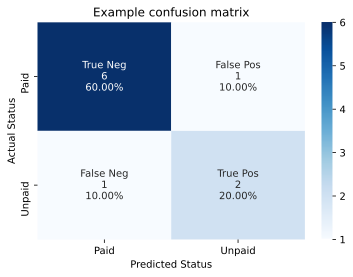

In [127]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
g = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues',xticklabels = ['Paid','Unpaid'], yticklabels = ['Paid','Unpaid'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Example confusion matrix')
plt.show(g);